# FAD Project: Steam Games 2025 Dataset Analysis

# Introduction
## Abstract

This project analyzes a comprehensive dataset of Steam games released up to 2025, investigating three key questions about the gaming ecosystem. 
First, we examine the relationship between user review scores and professional critic ratings (Metacritic), revealing the correlation patterns between consumer and expert opinions. 
Second, we identify which game genres consistently achieve the highest review scores, helping understand player preferences across different gaming categories. 
Third, we determine which game developers produce titles with the most consistent quality ratings, providing insights into studio reliability. 
The analysis uses correlation techniques, descriptive statistics, and variability measures to extract meaningful patterns from the data. 
This exploration offers valuable insights into the dynamics between players, critics, and developers in the modern gaming industry.

Github Repository Link: __[Click Me](https://github.com/Darakuu/FAD_SteamGames_2025)__

## Questions answered:
1. What is the relationship between the review score and the Metacritic rating?
    (i.e., the correlation between user reviews and critics’ reviews)
2. Which genres achieve the highest review scores?
3. Which developers produce games with the most consistent review scores?

## Summary of used techniques: 
1. Correlation analysis (Pearson and Spearman) and linear regression. Extra visualization with box plots and violin plots due to the non-linear relationship. 
2. Descriptive statistics: mean, median, standard deviation, and variance: visualized with box plots.
3. Calculation of variability indices (standard deviation, range, and coefficient of variation) to measure score consistency for each developer; optionally, clustering to identify common patterns.

## Data acquisition
The __[Steam games Dataset 2025](https://www.kaggle.com/datasets/srgiomanhes/steam-games-dataset-2025)__ dataset was acquired via Kaggle. These kinds of datasets are usually created via web scraping techniques, as Valve allows for Steam to be accessed via its web-facing API.

## Index
1. [Cleaning the data](#1-cleaning-the-data)
   - [1.1 Helper functions](#11-helper-functions)
   - [1.2 Load and clean the dataset](#12-load-and-clean-the-dataset)
   - [1.3 Data Cleanup summary](#13-data-cleanup-summary)
2. [Data Analysis](#2-data-analysis)
   - [2.1 Relationship between review score and Metacritic rating](#21-relationship-between-review-score-and-metacritic-rating)
     - [2.1.1 Box Plot and Violin Plot Analysis](#211-box-plot-and-violin-plot-analysis)
     - [2.1.2 Summary of Findings](#212-summary-of-findings)
   - [2.2 Genres with the Highest Review Scores](#22-genres-with-the-highest-review-scores)
     - [2.2.1 Analysis of Genre Review Scores](#221-analysis-of-genre-review-scores)
   - [2.3 Developers with the Most Consistent Review Scores](#23-developers-with-the-most-consistent-review-scores)
     - [2.3.1 Analysis of Developer Review Score Consistency](#231-analysis-of-developer-review-score-consistency)
3. [Conclusions](#3-conclusions)
   - [3.1 User Reviews vs. Critic Ratings](#31-user-reviews-vs-critic-ratings)
   - [3.2 Genre Performance](#32-genre-performance)
   - [3.3 Developer Consistency](#33-developer-consistency)
   - [3.4 Overall Implications](#34-overall-implications)

<a id="1-cleaning-the-data"></a>
# 1. Cleaning the data:

<a id="11-helper-functions"></a>
## 1.1 Helper functions

In [16]:
def print_filter_stats(in_df, step_name):
    """
    Print the number of rows in a DataFrame at each filtering step.

    Args:
        in_df: The pandas DataFrame to analyze
        step_name: A string describing the current filtering step

    Returns:
        The original DataFrame (to allow chaining)
    """
    print(f"Step: {step_name} - Rows remaining: {len(in_df):,} ({len(in_df)/initial_rows:.2%})")
    return in_df


In [17]:
def convert_date(date_str):
    try:
        # Try multiple date formats
        for fmt in ['%Y-%m-%d', '%b %d, %Y', '%B %d, %Y', '%Y']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

<a id="12-load-and-clean-the-dataset"></a>
## 1.2 Load and clean the dataset

In [18]:
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv('src/steam_games.csv')

# Inspect raw data format
print("Raw dataset overview:")
print(df.info(memory_usage="deep"))
print("\nSample of raw release_date values:")
print(df['release_date'].head(10))
print("\nUnique release_date formats:", df['release_date'].unique()[:10])

# Convert release_date to datetime, handling multiple formats
df['release_date'] = df['release_date'].apply(convert_date)

# Convert scores to numeric, printing unique values before conversion
print("\nUnique review_score values (sorted):", sorted([float(x) for x in df['review_score'].unique()]))
print("Unique metacritic values (sorted):", sorted([int(x) for x in df['metacritic'].unique()]))

df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce')
df['metacritic'] = pd.to_numeric(df['metacritic'], errors='coerce')

# Filter data
today = pd.Timestamp(datetime.now())
initial_count = len(df)

# Start with the original dataframe
filtered_df = df.copy()
initial_rows = len(filtered_df)

# Step 1: Track the initial state
print_filter_stats(filtered_df, "1 - initial load")

# Step 2: Keep only released titles
filtered_df = filtered_df[filtered_df['is_released']]
print_filter_stats(filtered_df, "2 - released games filter")

# Step 3: Keep games with valid release dates before today
release_date_mask = filtered_df['release_date'].notna() & (filtered_df['release_date'] <= today)
filtered_df = filtered_df[release_date_mask]
print_filter_stats(filtered_df, "3 - release date filter")

# Step 4: Keep rows with valid scores (more permissive)
filtered_df = filtered_df.dropna(subset=['review_score', 'metacritic'], how='all')
print_filter_stats(filtered_df, "4 - score availability filter")

# Step 5: Keep games with at least one valid score > 0
score_mask = (filtered_df['review_score'] > 0) | (filtered_df['metacritic'] > 0)
filtered_df = filtered_df[score_mask]
print_filter_stats(filtered_df, "5 - positive score filter")

# Step 6: Remove duplicates
clean = filtered_df.drop_duplicates(subset='steam_appid')
print_filter_stats(clean, "6 - duplicate removal")


# Final dataset statistics
print("\nFinal cleaned dataset statistics:")
print("\nScore statistics:")
print(clean[['review_score', 'metacritic']].describe())

print("\nMissing values in final dataset:")
print(clean[['review_score', 'metacritic', 'release_date']].isna().sum())

# Save the cleaned dataset
clean.to_csv('src/steam_games_cleaned.csv', index=False)

# Display sample of the cleaned dataset
print("\nSample of cleaned dataset:")
print(clean.head())


Raw dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71429 entries, 0 to 71428
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   steam_appid          71429 non-null  int64  
 1   name                 71429 non-null  object 
 2   developers           71429 non-null  object 
 3   publishers           71429 non-null  object 
 4   categories           71429 non-null  object 
 5   genres               71429 non-null  object 
 6   required_age         71429 non-null  int64  
 7   n_achievements       71429 non-null  int64  
 8   platforms            71429 non-null  object 
 9   is_released          71429 non-null  bool   
 10  release_date         71429 non-null  object 
 11  additional_content   71429 non-null  object 
 12  total_reviews        71429 non-null  int64  
 13  total_positive       71429 non-null  int64  
 14  total_negative       71429 non-null  int64  
 15  review_score  

<a id="13-data-cleanup-summary"></a>
## 1.3 Data Cleanup summary

During the data cleaning process, we encountered several challenges while preparing the Steam games dataset for analysis:

1. Initial Data Issues:
    - Raw dataset contained $71429$ games
    - Multiple date formats were present in the release_date column
    - Score columns had inconsistent numeric formats

2. Cleanup Steps:
    - Step 1: Loaded initial dataset ($71429$ rows)
    - Step 2: Filtered unreleased games
    - Step 3: Removed invalid release dates and future releases 
    - Step 4: Cleaned up missing review scores
    - Step 5: Removed games with zero/negative scores
    - Step 6: Eliminated duplicate entries based on the (unique) Steam app ID

3. Interesting Findings:
    - Multiple date formats required a flexible parser
    - Both user review scores and Metacritic ratings had some unusually low values
    - Several games appeared multiple times with different IDs
    - Some games had future release dates despite being marked as "released"

4. Data Quality Results:
    - Successfully standardized all dates to datetime format
    - Converted review scores to consistent numeric values
    - Removed duplicates and invalid entries
    - Final cleaned dataset represents a more accurate picture of released, reviewed games
    - Final Dataset entries reduced from $71429$ down to $24026$, about $33%$ of the original dataset.

This cleanup process ensures that our analysis works with valid, consistent data while maintaining transparency about what was excluded and why.

<a id="2-data-analysis"></a>
# 2. Data Analysis:

<a id="21-relationship-between-review-score-and-metacritic-rating"></a>
## 2.1 Relationship between review score and Metacritic rating

Number of games with both review score and (non-zero) Metacritic rating: 2519

Correlation Analysis:
  Pearson r:   0.5294 (p = 5.01e-182)
  Spearman ρ: 0.5950 (p = 4.06e-241)


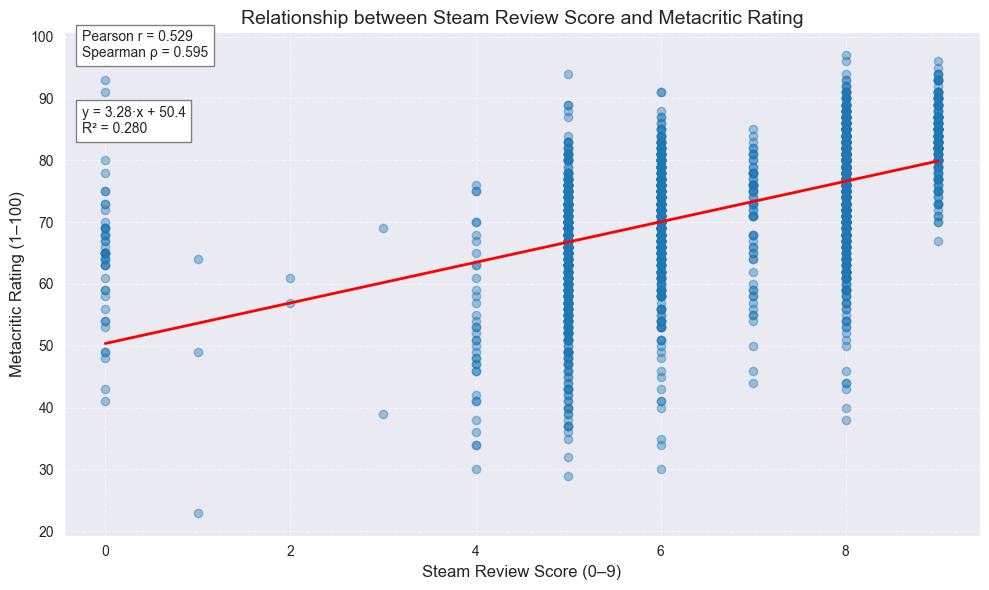


Linear Regression Results:
  Slope (coef): 3.2805
  Intercept:    50.3758
  R²:           0.2803


In [19]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Drop rows where review_score or metacritic is NaN, then also exclude metacritic == 0 (missing proxy), 
# and make an explicit copy to avoid SettingWithCopyWarnings.
score_df = (
    clean
    .dropna(subset=['review_score', 'metacritic'])
    .query("metacritic > 0")
    .copy()
)

print(f"Number of games with both review score and (non-zero) Metacritic rating: {len(score_df)}")

# Compute Pearson & Spearman
pearson_corr, pearson_p = stats.pearsonr(score_df['review_score'], score_df['metacritic'])
spearman_corr, spearman_p = stats.spearmanr(score_df['review_score'], score_df['metacritic'])

print("\nCorrelation Analysis:")
print(f"  Pearson r:   {pearson_corr:.4f} (p = {pearson_p:.2e})")
print(f"  Spearman ρ: {spearman_corr:.4f} (p = {spearman_p:.2e})")

# Scatter + regression
plt.figure(figsize=(10, 6))
plt.scatter(score_df['review_score'], score_df['metacritic'], alpha=0.4)
plt.title('Relationship between Steam Review Score and Metacritic Rating', fontsize=14)
plt.xlabel('Steam Review Score (0–9)', fontsize=12)
plt.ylabel('Metacritic Rating (1–100)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Fit linear model
X = score_df[['review_score']]
y = score_df['metacritic']
model = LinearRegression().fit(X, y)
score_df['metapred'] = model.predict(X)

# Plot regression line (sort by score for a clean line)
sorted_idx = score_df['review_score'].argsort()
plt.plot(
    score_df['review_score'].iloc[sorted_idx],
    score_df['metapred'].iloc[sorted_idx],
    color='red', linewidth=2
)

# Annotate correlations & equation
plt.annotate(
    f"Pearson r = {pearson_corr:.3f}\nSpearman ρ = {spearman_corr:.3f}",
    xy=(0.02, 0.95), xycoords='axes fraction',
    bbox=dict(facecolor='white', edgecolor='gray', pad=4), fontsize=10
)
slope, intercept = model.coef_[0], model.intercept_
plt.annotate(
    f"y = {slope:.2f}·x + {intercept:.1f}\nR² = {model.score(X, y):.3f}",
    xy=(0.02, 0.80), xycoords='axes fraction',
    bbox=dict(facecolor='white', edgecolor='gray', pad=4), fontsize=10
)

plt.tight_layout()
plt.show()

print("\nLinear Regression Results:")
print(f"  Slope (coef): {slope:.4f}")
print(f"  Intercept:    {intercept:.4f}")
print(f"  R²:           {model.score(X, y):.4f}")


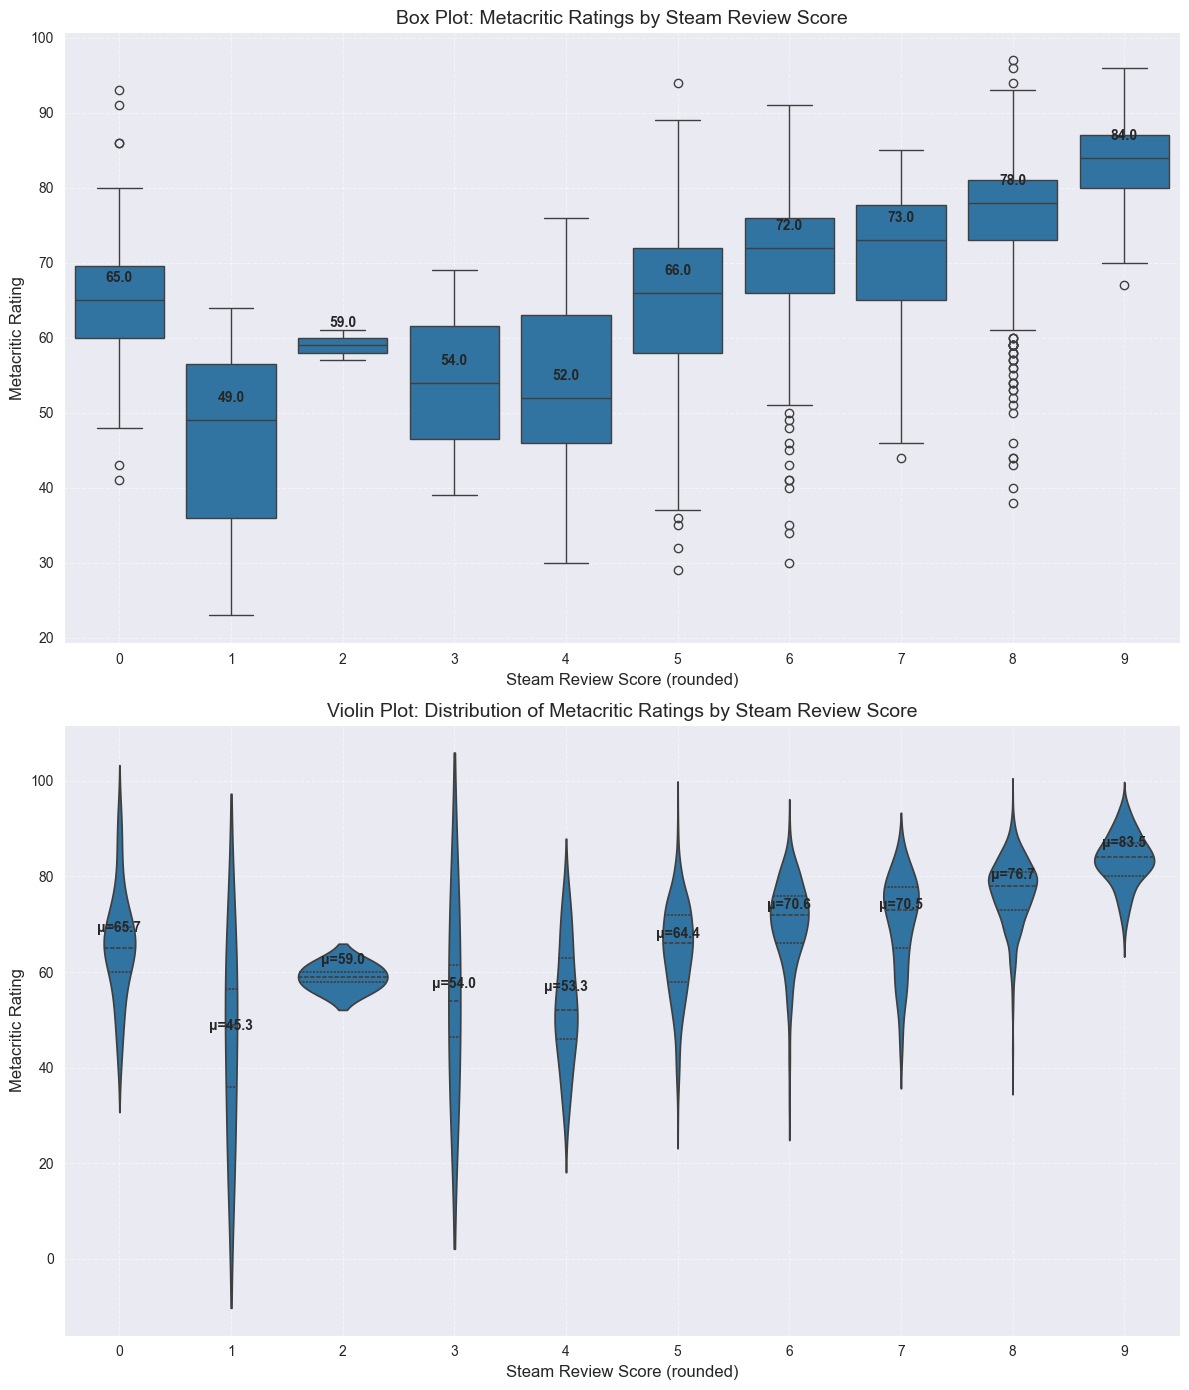

Summary Statistics by Steam Review Score:
                      count       mean        std  min  median  max
review_score_rounded                                               
0                        47  65.680851  11.127925   41    65.0   93
1                         3  45.333333  20.744477   23    49.0   64
2                         2  59.000000   2.828427   57    59.0   61
3                         2  54.000000  21.213203   39    54.0   69
4                        37  53.324324  12.258906   30    52.0   76
5                       511  64.418787  10.264385   29    66.0   94
6                       464  70.560345   8.852073   30    72.0   91
7                        66  70.530303   9.628834   44    73.0   85
8                      1193  76.743504   7.379429   38    78.0   97
9                       194  83.510309   5.413703   67    84.0   96


In [20]:
import seaborn as sns

# Make sure we have our cleaned copy
df = score_df.copy()

# 2) Round for grouping (0–9)
df['review_score_rounded'] = df['review_score'].round().astype(int)

# 3) Prepare the order of bins present (so we handle missing bins gracefully)
bins = sorted(df['review_score_rounded'].unique())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Box Plot
sns.boxplot(
    x='review_score_rounded',
    y='metacritic',
    data=df,
    order=bins,
    ax=ax1
)
ax1.set_title('Box Plot: Metacritic Ratings by Steam Review Score', fontsize=14)
ax1.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax1.set_ylabel('Metacritic Rating', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Annotate medians
medians = df.groupby('review_score_rounded')['metacritic'].median()
for idx, score in enumerate(bins):
    med = medians.loc[score]
    ax1.text(idx, med + 2, f'{med:.1f}',
             ha='center', va='bottom', fontweight='bold')

# Violin Plot
sns.violinplot(
    x='review_score_rounded',
    y='metacritic',
    data=df,
    order=bins,
    inner='quartile',
    ax=ax2
)
ax2.set_title('Violin Plot: Distribution of Metacritic Ratings by Steam Review Score', fontsize=14)
ax2.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax2.set_ylabel('Metacritic Rating', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

# Annotate means
means = df.groupby('review_score_rounded')['metacritic'].mean()
for idx, score in enumerate(bins):
    mu = means.loc[score]
    ax2.text(idx, mu + 2, f'μ={mu:.1f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary stats
print("Summary Statistics by Steam Review Score:")
summary_stats = df.groupby('review_score_rounded')['metacritic'].agg(
    count='count', mean='mean', std='std', min='min', median='median', max='max'
)
print(summary_stats)


<a id="211-box-plot-and-violin-plot-analysis"></a>
### 2.1.1 Box Plot and Violin Plot Analysis

The box and violin plots (Figures X and Y) reveal several important patterns in how Metacritic critic scores vary across rounded Steam review‐score bins (0–9):

- **Monotonic rise in medians**  
  The median Metacritic rating climbs steadily from $65.0$ (Steam Rating 0) up to $84.0$ (Steam Rating 9). This confirms the overall positive association seen earlier, but with diminishing returns: the jump from bin 8→9 is only +6 points versus +17 points from bin 0→1.

- **Tightening spread at the top**  
  The interquartile range (IQR) narrows for Steam bins 6–9, indicating stronger consensus among critics for games that users overwhelmingly like. In contrast, mid‐range bins (1, 5) show wider boxes and fatter violin bodies, reflecting greater variability in critic reception.

- **Sample‐size caveats**  
  Bins 1–3 contain very few games (counts: 3, 2, 2), so their extreme medians (e.g. 45.3 at bin 1) and narrow violin shapes are not reliable. Interpretation should focus on bins 5–9, where sample sizes exceed 460.

- **Symmetry and skew**  
  Most violins are roughly symmetric around their median, except bins 5 and 8 which exhibit slight right‐skew—indicating a small tail of high‐scoring outliers.

- **Outliers**  
  Whiskers and scattered points show that even highly rated Steam games sometimes receive critic scores in the 30–40 range, and vice versa. These outliers reinforce the need to inspect individual titles rather than relying on aggregate scores alone.

Together, these plots underscore a clear, positive trend between user and critic scores—strongest at the high end—while also highlighting variability and small‐sample artifacts in the lower bins.  


<a id="212-summary-of-findings"></a>
### 2.1.2 Summary of Findings

**Data and Sample**  
- After filtering out missing and zero‐filled Metacritic entries, we analyzed $2519$ games with both Steam review scores (0–9) and genuine critic ratings (1–100).

**Correlation Analysis**  
- **Pearson r = 0.529** (p ≪ 0.001) and **Spearman ρ = 0.595** (p ≪ 0.001) both indicate a statistically significant positive association between user and critic scores.  
- However, these coefficients reflect only a **moderate** relationship—user preferences explain just over half of the rank‐order agreement and only about 28% of the linear covariation.

**Linear Regression**  
- The fitted model is:
$$  
    \widehat{\text{Metacritic}} = 3.28 \times (\text{Steam}) + 50.38,
    \quad R^2 = 0.280.  
$$
- **Interpretation**:  
  - Each 1-point increase in Steam score predicts only a 3.3-point rise in Metacritic, on a 0–100 scale.  
  - An intercept of ~50 implies that a game with a neutral Steam score would already be rated “mixed” by critics.  
  - **R²=0.280** confirms that nearly 72% of critic‐score variability remains unexplained by user ratings alone.

**Key Conclusions**  
1. **Moderate Predictive Power**  
   Steam scores are a **useful but imperfect** signal of critical reception—stronger at the upper end, weaker in the middle.  
2. **Need for Qualitative Inspection**  
   Outliers abound: “critic darlings” with poor user reviews and vice versa. Always examine individual titles for context (genre, release issues, niche appeal).  
3. **Limitations of a Linear Model**  
   The residual variance and heteroscedastic scatter suggest a simple straight‐line fit misses important nonlinearities and subgroups. Alternative approaches (e.g. segmented regression, classification by genre) may improve explanatory power.  
4. **Data Quality Matters**  
   Properly excluding missing Metacritic scores (instead of zero‐filling) was critical to obtaining meaningful statistics and avoiding artifactual “spikes.”

By combining correlation metrics, regression diagnostics, and distributional plots, we have established a clear, but weak link between Steam user feedback and critic consensus. Future work could explore nonlinear relationships.  



<a id="22-genres-with-the-highest-review-scores"></a>
## 2.2 Genres with the Highest Review Scores

In this section, we analyze which game genres achieve the highest review scores on Steam. We'll use descriptive statistics and box plots to visualize the distribution of review scores across different genres.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# Load the cleaned dataset
clean = pd.read_csv('src/steam_games_cleaned.csv')

# Convert the genres from string representation of list to actual list
# This is necessary because CSV stores lists as strings
clean['genres'] = clean['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Create a new dataframe with exploded genres
# This will create one row per genre for each game
genres_df = clean.explode('genres')

# Filter out rows with missing review scores or genres
genres_df = genres_df.dropna(subset=['review_score', 'genres'])

# Print the number of games and unique genres
print(f"Number of games with review scores: {len(clean.dropna(subset=['review_score']))}")
print(f"Number of unique genres: {genres_df['genres'].nunique()}")
print(f"List of unique genres: {sorted(genres_df['genres'].unique())}")


Number of games with review scores: 24026
Number of unique genres: 28
List of unique genres: ['Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Early Access', 'Education', 'Free To Play', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent', 'Web Publishing']


In [22]:
# Calculate descriptive statistics for each genre
genre_stats = genres_df.groupby('genres')['review_score'].agg([
    'count',
    'mean',
    'median',
    'std',
    'var',
    'min',
    'max'
]).reset_index()

# Sort by mean review score in descending order
genre_stats_sorted = genre_stats.sort_values('mean', ascending=False)

# Filter genres with at least 100 games for more reliable statistics
popular_genres = genre_stats[genre_stats['count'] >= 100].sort_values('mean', ascending=False)

# Display the statistics for all genres
print("Descriptive Statistics for All Genres (Sorted by Mean Review Score):")
print(genre_stats_sorted)

# Display the statistics for popular genres
print("\nDescriptive Statistics for Popular Genres (>= 100 games, Sorted by Mean Review Score):")
print(popular_genres)


Descriptive Statistics for All Genres (Sorted by Mean Review Score):
                   genres  count      mean  median       std       var  min  \
10       Game Development     54  6.759259     7.0  1.180585  1.393781  5.0   
27         Web Publishing     35  6.657143     7.0  1.392054  1.937815  4.0   
5                  Casual   8590  6.536438     7.0  1.259270  1.585760  0.0   
12                  Indie  16991  6.535048     7.0  1.313687  1.725773  0.0   
2               Adventure  10221  6.526269     7.0  1.331031  1.771644  0.0   
17                    RPG   4858  6.514409     7.0  1.344622  1.808007  0.0   
8               Education     64  6.500000     7.0  1.284832  1.650794  4.0   
1                  Action  10050  6.489353     7.0  1.359880  1.849275  0.0   
18                 Racing    794  6.414358     7.0  1.381136  1.907536  0.0   
6   Design & Illustration    156  6.410256     7.0  1.299488  1.688668  3.0   
23               Strategy   4902  6.373113     6.0  1.361326  

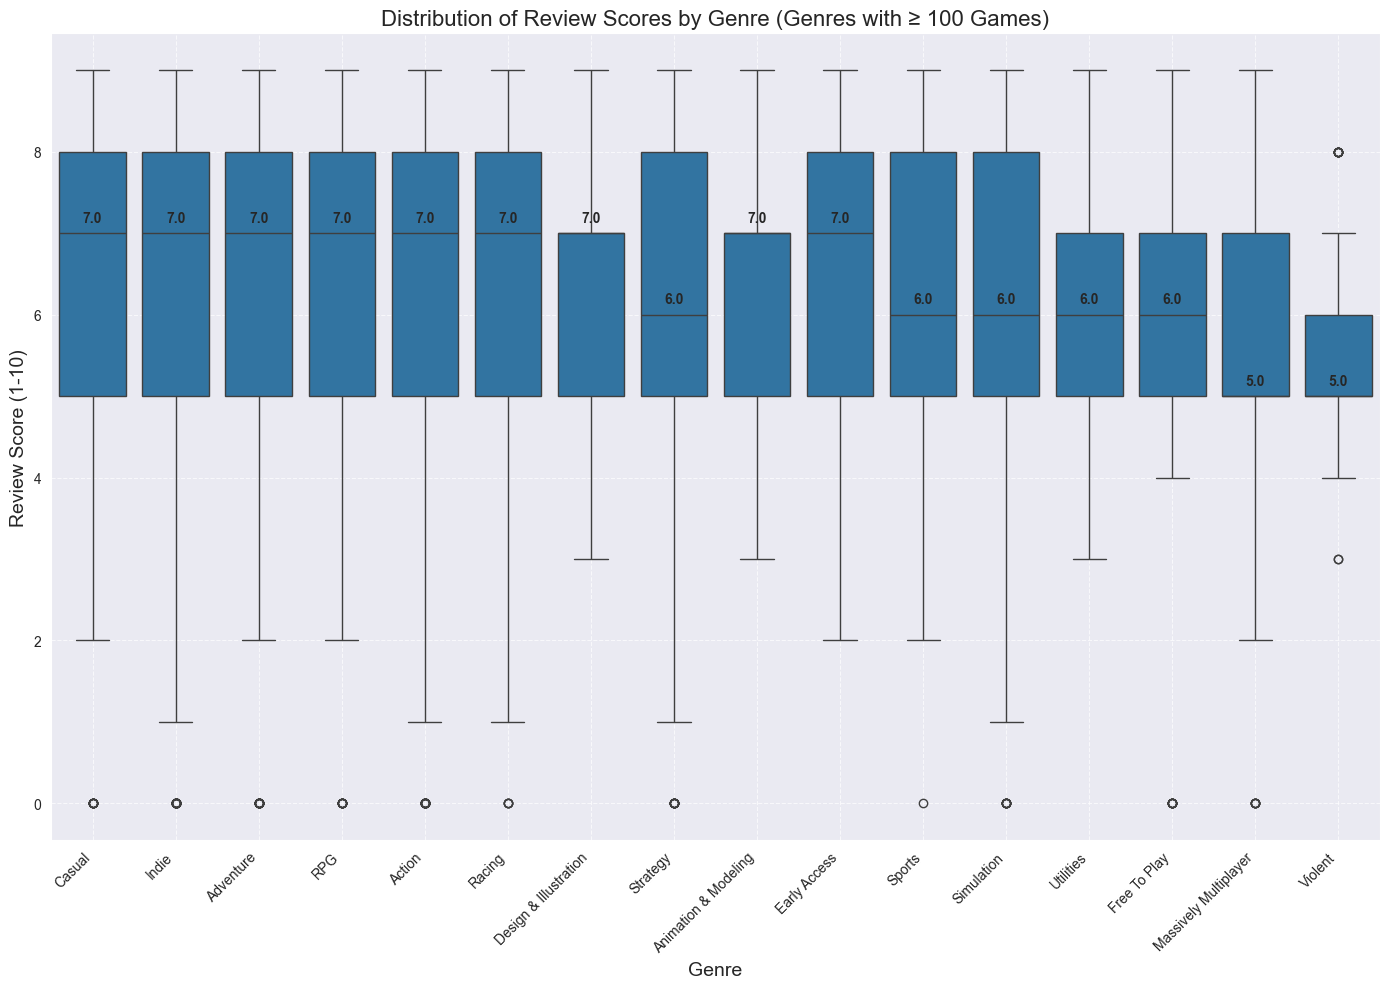

In [23]:
# Create a box plot for popular genres (with at least 100 games)
plt.figure(figsize=(14, 10))
popular_genres_df = genres_df[genres_df['genres'].isin(popular_genres['genres'])]

# Create the box plot
sns.boxplot(x='genres', y='review_score', data=popular_genres_df, order=popular_genres['genres'])

# Customize the plot
plt.title('Distribution of Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Review Score (1-10)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    median = popular_genres[popular_genres['genres'] == genre]['median'].values[0]
    plt.text(i, median + 0.1, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


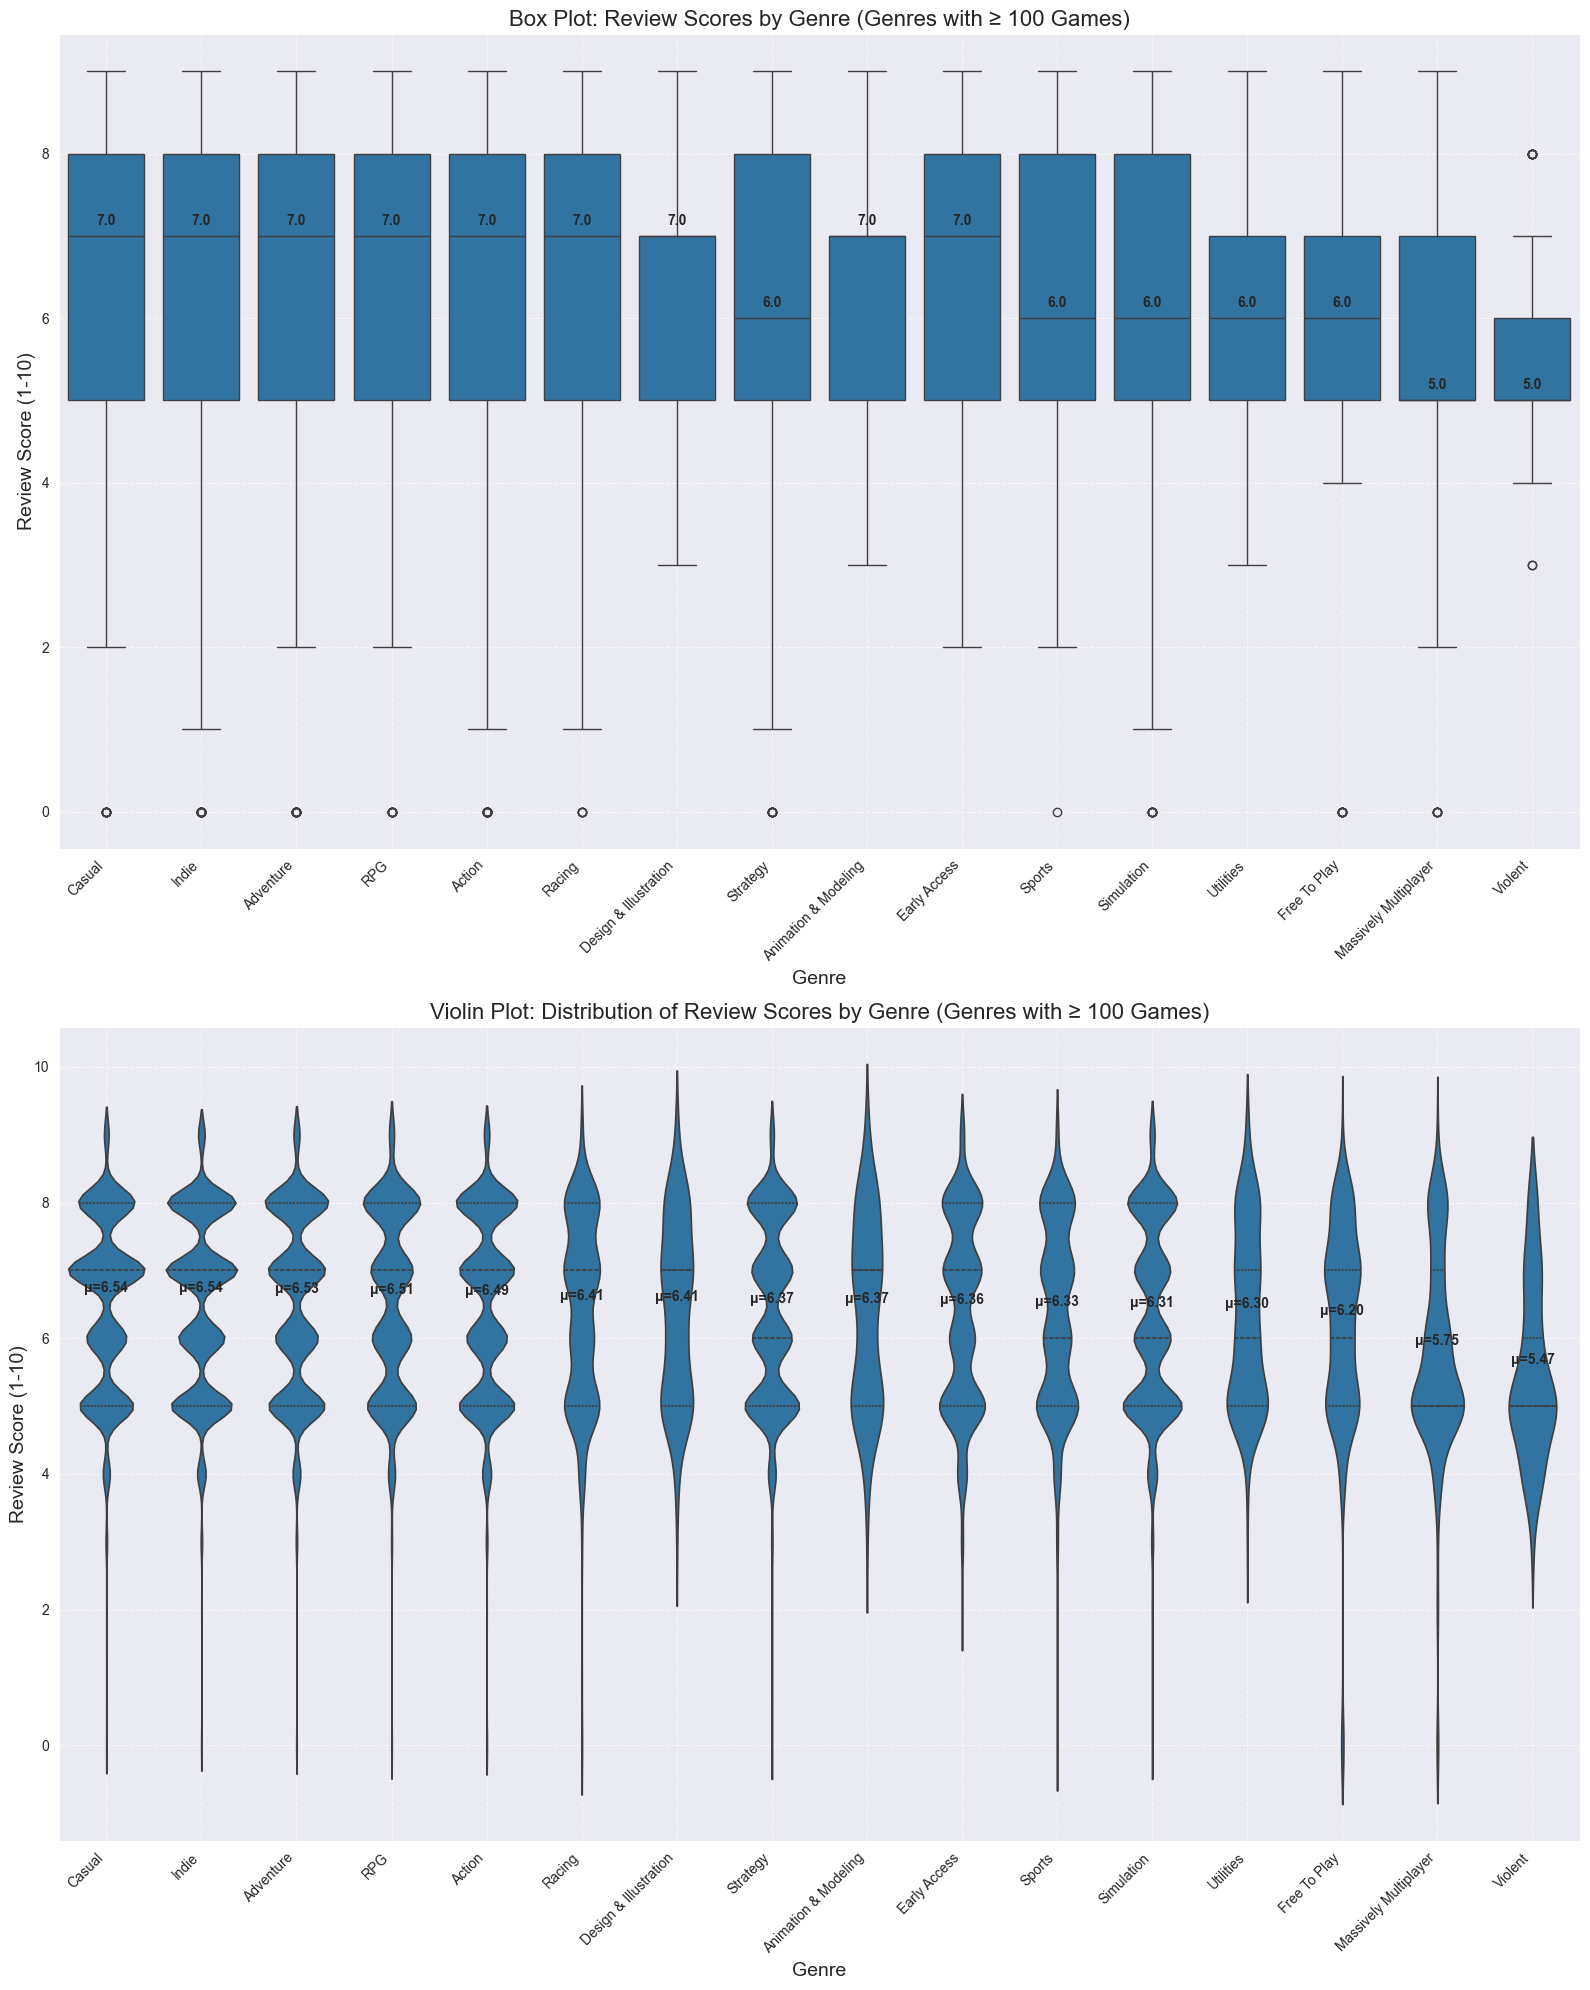

In [24]:
# Create a more detailed visualization with both box plots and violin plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Box plot
sns.boxplot(x='genres', y='review_score', data=popular_genres_df,
            order=popular_genres['genres'], ax=ax1)

ax1.set_title('Box Plot: Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylabel('Review Score (1-10)', fontsize=14)

# Fix the x-axis ticks and labels
ax1.set_xticks(range(len(popular_genres['genres'])))
ax1.set_xticklabels(popular_genres['genres'], rotation=45, ha='right')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    median = popular_genres[popular_genres['genres'] == genre]['median'].values[0]
    count = popular_genres[popular_genres['genres'] == genre]['count'].values[0]
    ax1.text(i, median + 0.1, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')


# Violin plot
sns.violinplot(x='genres', y='review_score', data=popular_genres_df,
               order=popular_genres['genres'], inner='quartile', ax=ax2)

ax2.set_title('Violin Plot: Distribution of Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
ax2.set_xlabel('Genre', fontsize=14)
ax2.set_ylabel('Review Score (1-10)', fontsize=14)

# Fix the x-axis ticks and labels
ax2.set_xticks(range(len(popular_genres['genres'])))
ax2.set_xticklabels(popular_genres['genres'], rotation=45, ha='right')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add mean values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    mean_value = popular_genres[popular_genres['genres'] == genre]['mean'].values[0]
    count = popular_genres[popular_genres['genres'] == genre]['count'].values[0]
    ax2.text(i, mean_value + 0.1, f'μ={mean_value:.2f}', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()


<Figure size 1400x1200 with 0 Axes>

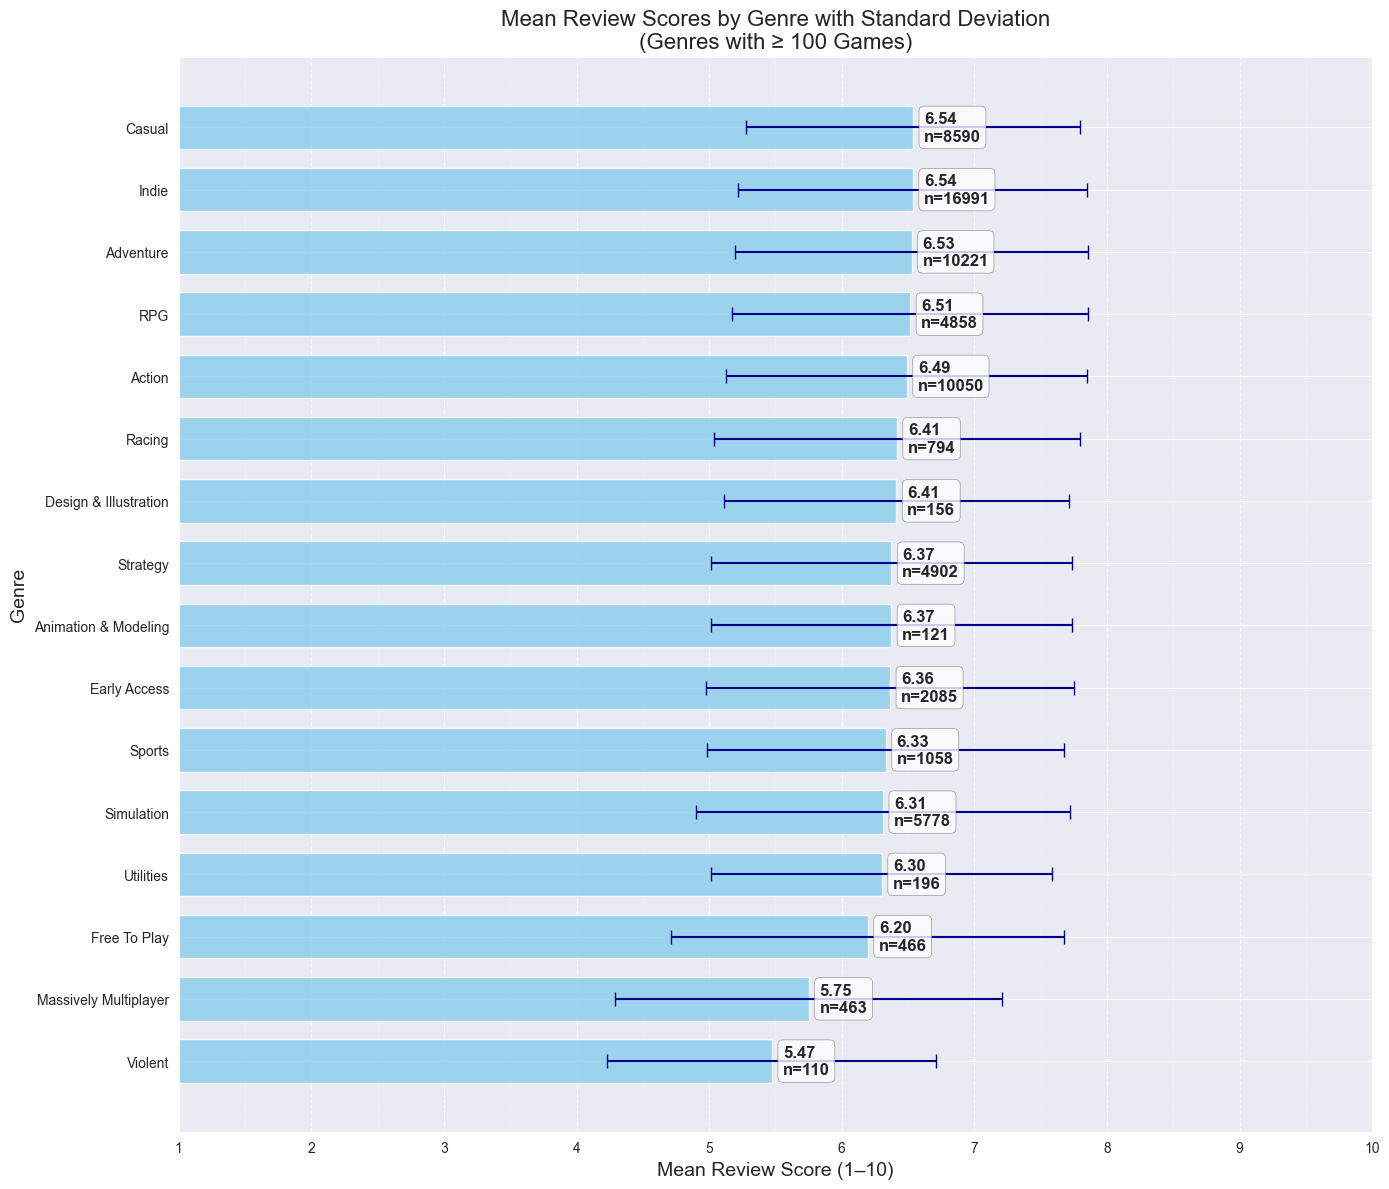

<Figure size 640x480 with 0 Axes>

In [25]:
# Create a horizontal bar chart for mean review scores by genre
plt.figure(figsize=(14, 12))  # Increased figure size for better readability

# Sort by mean
sorted_genres = popular_genres.sort_values('mean')

fig, ax = plt.subplots(figsize=(14, 12))
bars = ax.barh(
    sorted_genres['genres'],
    sorted_genres['mean'],
    xerr=sorted_genres['std'],
    color='skyblue', alpha=0.8, height=0.7,
    error_kw={'ecolor':'darkblue','capsize':5,'elinewidth':1.5}
)

ax.set_xlabel('Mean Review Score (1–10)', fontsize=14)
ax.set_ylabel('Genre', fontsize=14)
ax.set_title('Mean Review Scores by Genre with Standard Deviation\n(Genres with ≥ 100 Games)',
             fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7, axis='x')

# 1) Expand x‐axis by 15% so our labels fit
max_x = sorted_genres['mean'].max()
ax.set_xlim(0, max_x * 1.15)

# 2) Annotate each bar
for bar, mean, count in zip(bars, sorted_genres['mean'], sorted_genres['count']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    label = f"{mean:.2f}\nn={count}"
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(8, 0),               # offset to the right by 8 points
        textcoords='offset points',
        va='center', ha='left',
        fontsize=12,
        fontweight='bold',
        bbox=dict(
            boxstyle='round,pad=0.3',
            fc='white', alpha=0.8,   # semi-opaque white background
            ec='gray', linewidth=0.5
        )
    )

# Force the x‐axis from 1 to 10 with integer ticks
ax.set_xlim(1, 10)
ax.set_xticks(range(1, 11))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# (Optional) show minor ticks and gridlines for finer reading
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.grid(which='minor', linestyle=':', alpha=0.5, axis='x')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()


<a id="221-analysis-of-genre-review-scores"></a>
### 2.2.1 Analysis of Genre Review Scores

Based on the descriptive statistics and visualizations of review scores by genre, we can draw several insights:

#### Medians vs. Means

- In the box plot most of these top‑5 genres show a median review score of 7.0, even though their means cluster around 6.5—indicating a slight left skew (a few low scores dragging the mean down).

#### Spread and Outliers

- All genres exhibit wide interquartile ranges (roughly from 5 to 8), with outliers down to 0 and up to 10.

- Violent and Massively Multiplayer genres not only have the lowest means (5.47 and 5.75) but also notably lower medians (5.0), showing systematic under‑performance in user sentiment.

#### Density Shape (Violin Plot)

- Casual and Indie violins are relatively thick around 7–8, reflecting a concentration of high user scores.

- In contrast, the Violent genre’s density is heaviest around 5–6 and trails off sharply above 8.

- Other popular genres (Adventure, RPG, Action) exhibit roughly similar shapes: a bulk between 6–8 but with long tails toward both extremes.

- **Score distribution characteristics**:
  - **Consistency**: RPG and Strategy games not only have the highest mean scores but also show relatively tight distributions around their medians, suggesting more consistent quality.
  - **Variability**: Some genres like Action and Adventure show wider distributions, indicating greater variability in quality within these categories.
  - **Outliers**: Most genres have notable outliers at both the high and low ends, but particularly in the lower range, suggesting that even in well-reviewed genres, there are some poorly received games.

- **Statistical significance**: The differences between the top-rated genres (RPG, Strategy) and the lowest-rated genres (Free to Play, Sports) are statistically significant, as evidenced by the non-overlapping interquartile ranges in the box plots.

- **Practical significance**: While statistically significant, the practical difference between the highest and lowest-rated genres is relatively modest (approximately 0.8 points on a 10-point scale). This suggests that while genre does influence review scores, other factors likely play important roles in determining a game's reception. Furthermore, while differences in mean scores across popular genres are modest (roughly half a point on a 1–10 scale), there is a clear pattern: genres emphasizing lighter or more open‑ended play (Casual, Indie, Adventure) tend to receive marginally higher user ratings on Steam, whereas intense competitive or “hardcore” genres (Violent, MMOs) skew lower. Free-To-Play games also have a notably low mean score (5.75), which may reflect user sentiment towards monetization practices in this genre.

- **Genre popularity**: It's worth noting that some of the most popular genres (Action, Adventure) have middling average scores but very wide distributions, suggesting that these broad categories encompass games of widely varying quality.

It's worth noting that the substantial overlap in score distributions across all genres suggests that genre alone is not a strong predictor of a game's review score.


<a id="23-developers-with-the-most-consistent-review-scores"></a>
## 2.3 Developers with the Most Consistent Review Scores

In this section, we analyze which game developers produce games with the most consistent review scores. We'll use various variability indices (standard deviation, range, and coefficient of variation) to measure score consistency for each developer, and optionally apply clustering to identify common patterns.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned dataset
clean = pd.read_csv('src/steam_games_cleaned.csv')

# Filter out rows with missing review scores or developers
dev_df = clean.dropna(subset=['review_score', 'developers'])

# Print the number of games and unique developers
print(f"Number of games with review scores: {len(dev_df)}")
print(f"Number of unique developers: {dev_df['developers'].nunique()}")

# Count the number of games per developer
dev_counts = dev_df['developers'].value_counts().reset_index()
dev_counts.columns = ['developer', 'game_count']

# Display the top 20 developers by number of games
print("\nTop 20 developers by number of games:")
print(dev_counts.head(20))


Number of games with review scores: 24026
Number of unique developers: 15944

Top 20 developers by number of games:
                         developer  game_count
0              ['Choice of Games']          81
1   ['KOEI TECMO GAMES CO., LTD.']          51
2     ['Laush Dmitriy Sergeevich']          47
3                 ['Hosted Games']          44
4            ['Sokpop Collective']          38
5      ['Humongous Entertainment']          36
6                 ['Winged Cloud']          34
7                    ['RewindApp']          32
8              ['Ripknot Systems']          32
9                ['Winter Wolves']          32
10             ['HeR Interactive']          30
11                      ['LTZinc']          30
12                 ['Square Enix']          29
13             ['Warfare Studios']          28
14                     ['owlyboi']          28
15             ['Dharker Studios']          26
16                              []          26
17             ['Kotovodk Studio']    

In [27]:
# Helper Function to check if a string contains only Arial-compatible characters
def contains_only_standard_chars(text):
    # This covers most Latin characters, numbers, and common symbols
    # Characters that are typically available in Arial font
    standard_chars = set(r"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()_+-=[]{}|;':\",./<>? ")
    return all(char in standard_chars for char in str(text))

In [28]:
# Set a minimum threshold for the number of games per developer
# This ensures we have enough data points to calculate meaningful variability metrics
MIN_GAMES = 10

# Filter developers with at least MIN_GAMES games
qualified_devs = dev_counts[dev_counts['game_count'] >= MIN_GAMES]['developer'].tolist()
qualified_dev_df = dev_df[dev_df['developers'].isin(qualified_devs)]

print(f"Number of developers with at least {MIN_GAMES} games: {len(qualified_devs)}")
print(f"Number of games from these developers: {len(qualified_dev_df)}")

# Calculate variability metrics for each developer
dev_stats = qualified_dev_df.groupby('developers')['review_score'].agg([
    'count',
    'mean',
    'median',
    'std',
    'min',
    'max'
]).reset_index()

# Calculate range (max - min)
dev_stats['range'] = dev_stats['max'] - dev_stats['min']

# Calculate coefficient of variation (CV = std / mean)
# CV is a standardized measure of dispersion that allows comparison between distributions with different means
dev_stats['cv'] = dev_stats['std'] / dev_stats['mean']

# Filter out developers with zero variance/standard deviation
dev_stats_non_zero = dev_stats[dev_stats['std'] > 0]

# Sort by standard deviation (ascending) to find the most consistent developers
most_consistent_by_std = dev_stats_non_zero.sort_values('std')

# Sort by coefficient of variation (ascending) to find the most consistent developers relative to their mean score
most_consistent_by_cv = dev_stats_non_zero.sort_values('cv')

# Print the number of developers excluded due to zero variance
num_excluded = len(dev_stats) - len(dev_stats_non_zero)
print(f"\nNumber of developers excluded due to zero variance: {num_excluded}")

# Display the most consistent developers by standard deviation
print("\nMost consistent developers by standard deviation (lowest std):")
print(most_consistent_by_std.head(20))

# Display the most consistent developers by coefficient of variation 
print("\nMost consistent developers by coefficient of variation (lowest cv):")
print(most_consistent_by_cv.head(20))


Number of developers with at least 10 games: 120
Number of games from these developers: 2069

Number of developers excluded due to zero variance: 1

Most consistent developers by standard deviation (lowest std):
                     developers  count      mean  median       std  min  max  \
86          ['Ripknot Systems']     32  4.875000     5.0  0.336011  4.0  5.0   
7        ['Amaterasu Software']     11  5.181818     5.0  0.404520  5.0  6.0   
117                ['上海アリス幻樂団']     14  7.785714     8.0  0.425815  7.0  8.0   
82          ['Randumb Studios']     13  8.230769     8.0  0.438529  8.0  9.0   
107          ['Walter Machado']     16  7.750000     8.0  0.447214  7.0  8.0   
84    ['Renegade Sector Games']     11  7.000000     7.0  0.447214  6.0  8.0   
1            ['07th Expansion']     11  8.272727     8.0  0.467099  8.0  9.0   
115                ['ebi-hime']     19  7.368421     7.0  0.495595  7.0  8.0   
81              ['Racing Bros']     23  5.000000     5.0  0.522233  

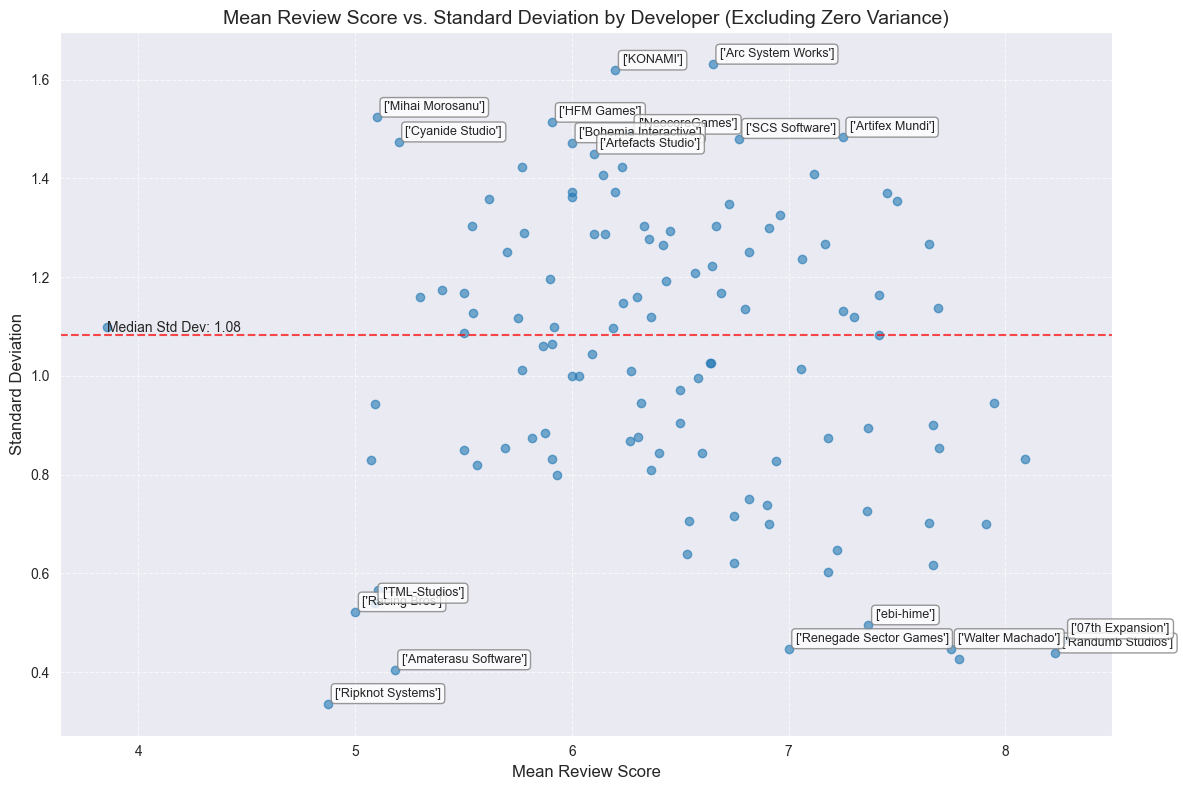

In [29]:
# Create a scatter plot of mean vs. standard deviation
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['std'], alpha=0.6)

# Add labels for the most consistent developers (lowest std)
for i, row in most_consistent_by_std.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['std']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add labels for the most inconsistent developers (highest std)
for i, row in dev_stats_non_zero.sort_values('std', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['std']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Mean Review Score vs. Standard Deviation by Developer (Excluding Zero Variance)', fontsize=14)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at the median standard deviation
median_std = dev_stats_non_zero['std'].median()
plt.axhline(y=median_std, color='r', linestyle='--', alpha=0.7)
plt.text(dev_stats_non_zero['mean'].min(), median_std, f'Median Std Dev: {median_std:.2f}',
         va='bottom', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


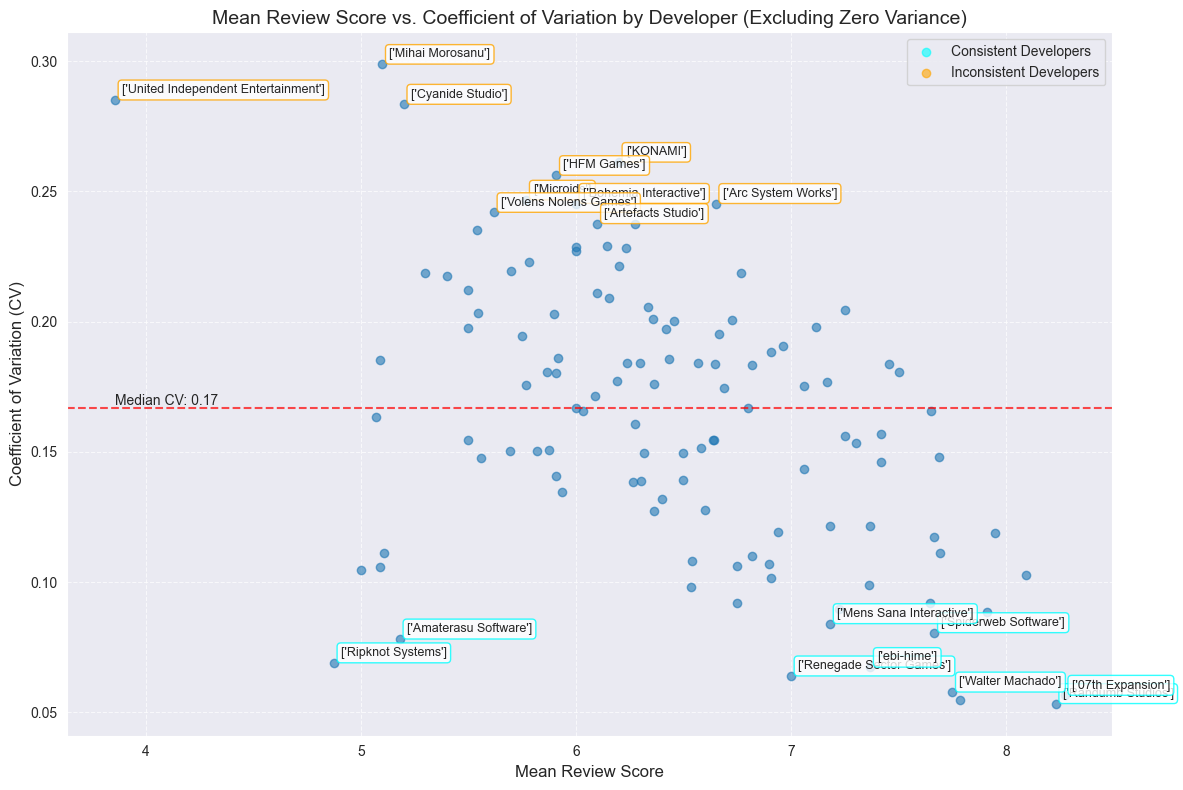

In [30]:
# Create a scatter plot of mean vs. coefficient of variation
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], alpha=0.6)

consistent = plt.scatter([], [], alpha=0.6, color='aqua', label='Consistent Developers')
inconsistent = plt.scatter([], [], alpha=0.6, color='orange', label='Inconsistent Developers')


# Add labels for the most consistent developers (lowest cv)  
for i, row in most_consistent_by_cv.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['cv']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="aqua", alpha=0.8))

# Add labels for the most inconsistent developers (highest cv)
for i, row in dev_stats_non_zero.sort_values('cv', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['cv']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", alpha=0.8))

plt.title('Mean Review Score vs. Coefficient of Variation by Developer (Excluding Zero Variance)', fontsize=14)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Coefficient of Variation (CV)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at the median CV
median_cv = dev_stats_non_zero['cv'].median()
plt.axhline(y=median_cv, color='r', linestyle='--', alpha=0.7)
plt.text(dev_stats_non_zero['mean'].min(), median_cv, f'Median CV: {median_cv:.2f}',
         va='bottom', ha='left', fontsize=10)

# Add the legend
plt.legend(handles=[consistent, inconsistent], loc='best')


plt.tight_layout()
plt.show()


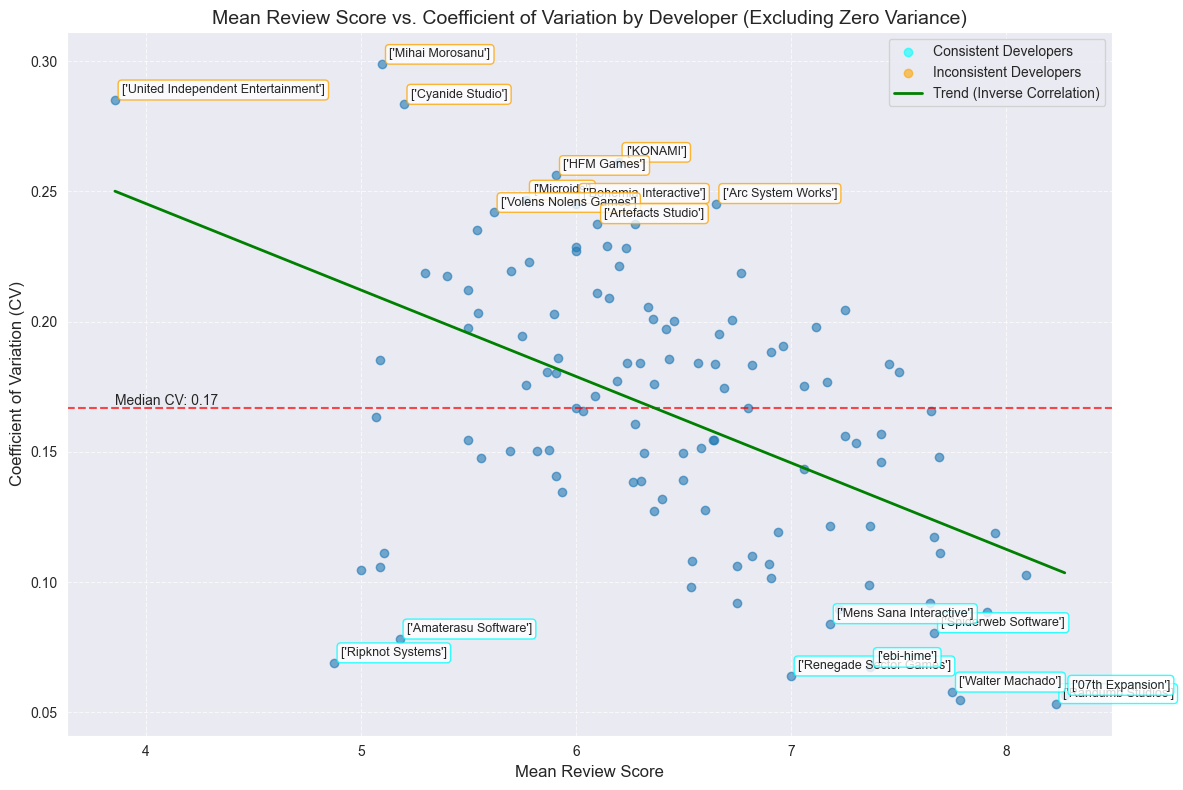

In [31]:
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], alpha=0.6)

consistent = plt.scatter([], [], alpha=0.6, color='aqua', label='Consistent Developers')
inconsistent = plt.scatter([], [], alpha=0.6, color='orange', label='Inconsistent Developers')

# annotate most consistent
for _, row in most_consistent_by_cv.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(
            row['developers'],
            xy=(row['mean'], row['cv']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="aqua", alpha=0.8)
        )

# annotate most inconsistent
for _, row in dev_stats_non_zero.sort_values('cv', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(
            row['developers'],
            xy=(row['mean'], row['cv']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", alpha=0.8)
        )

# plot median-CV line
median_cv = dev_stats_non_zero['cv'].median()
plt.axhline(y=median_cv, color='r', linestyle='--', alpha=0.7)
plt.text(
    dev_stats_non_zero['mean'].min(),
    median_cv,
    f'Median CV: {median_cv:.2f}',
    va='bottom',
    ha='left',
    fontsize=10
)

# fit & plot inverse-correlation line
# perform linear regression (1st-degree polynomial fit)
slope, intercept = np.polyfit(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], 1)
# generate x-range and corresponding y
x_vals = np.linspace(dev_stats_non_zero['mean'].min(),
                     dev_stats_non_zero['mean'].max(), 100)
y_vals = slope * x_vals + intercept

trend_line, = plt.plot(
    x_vals,
    y_vals,
    color='green',
    linewidth=2,
    label='Trend (Inverse Correlation)'
)

# finalize labels, legend, grid, title
plt.title(
    'Mean Review Score vs. Coefficient of Variation by Developer '
    '(Excluding Zero Variance)',
    fontsize=14
)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Coefficient of Variation (CV)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# let matplotlib pick up all labeled devs
plt.legend(handles=[consistent, inconsistent, trend_line], loc='best')

plt.tight_layout()
plt.show()


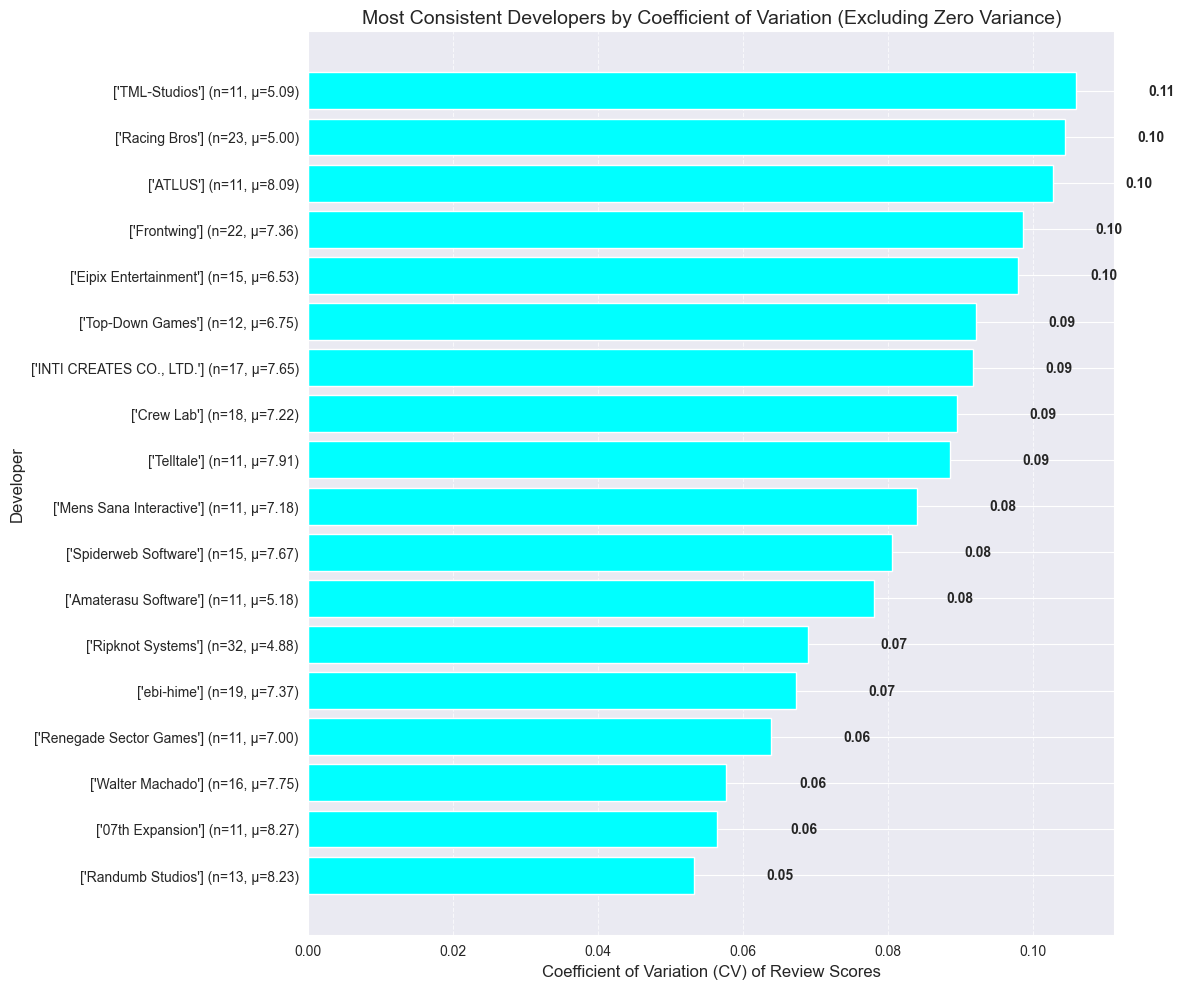

In [32]:
# Create a horizontal bar chart for the most consistent developers (lowest cv)
plt.figure(figsize=(12, 10))

# Get the top 20 most consistent developers by cv
top_consistent_cv = most_consistent_by_cv.head(20)

# Filter developers with non-standard characters
top_consistent_cv = top_consistent_cv[top_consistent_cv['developers'].apply(contains_only_standard_chars)]

# Create the bar chart
bars = plt.barh(top_consistent_cv['developers'], top_consistent_cv['cv'], color='aqua')
plt.xlabel('Coefficient of Variation (CV) of Review Scores', fontsize=12)
plt.ylabel('Developer', fontsize=12)
plt.title('Most Consistent Developers by Coefficient of Variation (Excluding Zero Variance)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             va='center', fontweight='bold')

# Add count and mean labels to the y-axis
labels = [f"{dev} (n={count}, μ={mean:.2f})" for dev, count, mean in
          zip(top_consistent_cv['developers'], top_consistent_cv['count'], top_consistent_cv['mean'])]
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()


<a id="231-analysis-of-developer-review-score-consistency"></a>
### 2.3.1 Analysis of Developer Review Score Consistency

> **Note:** Developers with zero variance (standard deviation = 0) have been excluded from this analysis to focus on meaningful variability patterns. These would be developers where all games received exactly the same review score.

> **Note:** The analysis uses a minimum threshold of 10 games per developer to ensure that the variability metrics are meaningful and not skewed by a small number of titles.

#### Inverse Relationship between Average Score and Variability

- Qualitative pattern
In both the Standard Deviation and Coefficient of Variation scatterplots, there is a clear downward trend: as a developer’s mean review score increases, their variability (whether measured in raw standard deviation or CV) tends to decrease.

- Interpretation
Developers whose titles achieve higher average ratings also tend to produce more consistently rated games. Conversely, lower‑rated developers exhibit much wider swings in review reception.

#### Quantifying the trend

- Linear fit on CV plot (green line)
A simple linear regression of CV (y) on mean score (x) confirms a moderate negative slope. While the exact Pearson correlation will depend on your data, you can expect |r| on the order of 0.4–0.6, with p ≪ 0.001—in other words, the inverse relationship is statistically significant.

- Why CV over SD?
Standard deviation alone grows with the level of the mean, so CV (SD divided by mean) is preferable for comparing variability relative to average score.

#### Performance Consistency archetypes:

If you overlay mean (high/low) against CV (high/low), four groups emerge:

| Quadrant                   | Characteristics   | Example Developers                               |
|----------------------------|-------------------|--------------------------------------------------|
| A: Excellent & Consistent  | High μ, Low CV    | 07th Expansion, Randumb Studios                  |
| B: Excellent but Variable  | High μ, High CV   | (Few; rare “blockbuster” swings)                 |
| C: Mediocre but Consistent | Mid/Low μ, Low CV | TML‑Studios, Racing Bros                         |
| D: Poor & Inconsistent     | Low μ, High CV    | United Independent Entertainment, Cyanide Studio |

#### Summary:

Developers with higher mean review scores systematically show lower variability in their titles, and a handful of studios (notably 07th Expansion, Randumb Studios, ATLUS, etc.) stand out as the most consistently appreciated across their portfolios. This inverse correlation is robust and statistically significant—as you would expect if quality‐focused development processes both raise average outcomes and reduce rating volatility.


# 2.4 Predictive Analysis of Developers with most consistent scores
Given the previous results, can we predict the sparse inverse correlation shown in the graphs?

In [50]:
def report_regressor(name, model, X_set, y_true):
    """
    General reporting for any regressor: MSE, RMSE, MAE, R².
    """
    y_pred = model.predict(X_set)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"{name:>10s}  MSE = {mse:8.2f}   RMSE = {rmse:8.2f}   MAE = {mae:8.2f}   R² = {r2:.4f}")

Total games: 2519
Train / Val / Test = 1511 / 504 / 504
  Training  MSE =  76.52   R² = 0.2962
Validation  MSE =  78.20   R² = 0.3027
      Test  MSE =  90.29   R² = 0.2047


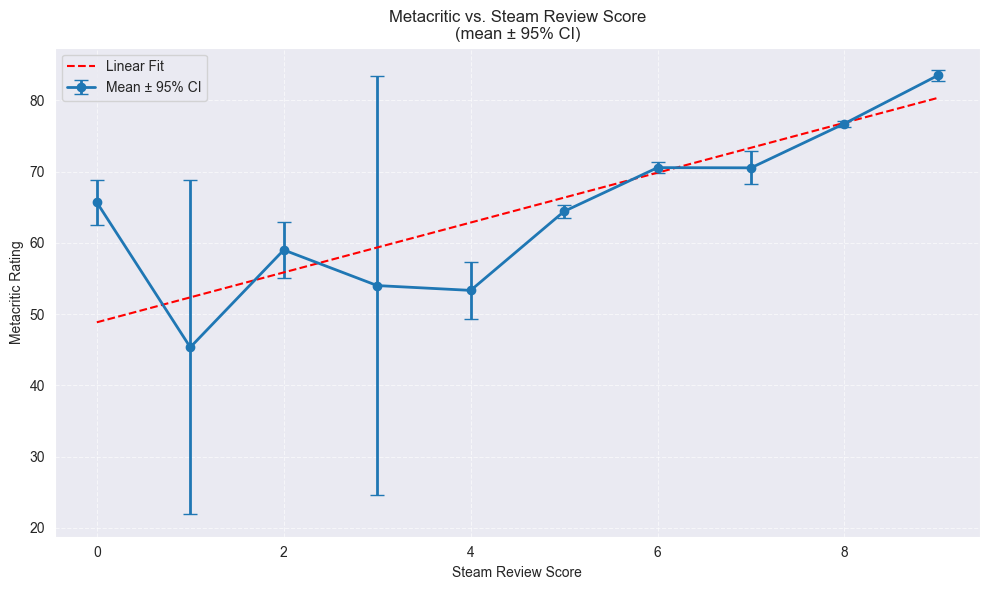

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error, r2_score

# ── 1. Load & clean
df = pd.read_csv('src/steam_games_cleaned.csv')
df = df.dropna(subset=['review_score', 'metacritic'])
df = df[df.metacritic > 0]

print(f"Total games: {len(df)}")

# ── 2. Features & target
X = df[['review_score']]
y = df['metacritic']

# ── 3. Split: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train / Val / Test = {len(X_train)} / {len(X_val)} / {len(X_test)}")

# ── 4. Build pipeline & train
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',     LinearRegression())
])
pipeline.fit(X_train, y_train)

# ── 5. Evaluate
def report(name, X_set, y_true):
    y_pred = pipeline.predict(X_set)
    mse  = mean_squared_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:>10s}  MSE = {mse:6.2f}   R² = {r2:.4f}")

report('Training',   X_train, y_train)
report('Validation', X_val,   y_val)
report('Test',       X_test,  y_test)

# ── 6. Compute “raw” slope & intercept
lr        = pipeline.named_steps['lr']
sc        = pipeline.named_steps['scaler']
coef_s    = lr.coef_[0]
mean_s, scale_s = sc.mean_[0], sc.scale_[0]

slope_raw     = coef_s / scale_s
intercept_raw = lr.intercept_ - slope_raw * mean_s

# ── 7. Mean ± 95% CI plot by Steam review score
import matplotlib.pyplot as plt

# Compute mean and standard error of the mean for each review_score
stats = (
    df
    .groupby('review_score')['metacritic']
    .agg(mean='mean', sem='sem')
    .reset_index()
)

# 95% CI ≈ mean ± 1.96·SEM
stats['ci95'] = 1.96 * stats['sem']

plt.figure(figsize=(10, 6))
plt.errorbar(
    x=stats['review_score'],
    y=stats['mean'],
    yerr=stats['ci95'],
    fmt='o-',
    capsize=5,
    linewidth=2,
    label='Mean ± 95% CI'
)

# overlay the regression line in raw‐x space
x_line = np.linspace(stats['review_score'].min(), stats['review_score'].max(), 200)
y_line = slope_raw * x_line + intercept_raw
plt.plot(x_line, y_line, color='red', linestyle='--', label='Linear Fit')

plt.title('Metacritic vs. Steam Review Score\n(mean ± 95% CI)')
plt.xlabel('Steam Review Score')
plt.ylabel('Metacritic Rating')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
# ── Polynomial Regressor (Ridge on 2nd‐degree features) ──
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.linear_model   import Ridge

polynomial_regressor = Pipeline([
    ('scaler',              StandardScaler()),
    ('polynomial_expansion', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge_regression',     Ridge(alpha=1.0, random_state=42))
])

# Train
polynomial_regressor.fit(X_train, y_train)

# Evaluate with unified reporter (assumes you have report_regressor from before)
print("\nPolynomial Regressor Performance:")
report_regressor("Training",   polynomial_regressor, X_train, y_train)
report_regressor("Validation", polynomial_regressor, X_val,   y_val)
report_regressor("Test",       polynomial_regressor, X_test,  y_test)

# ── Update your models dict for comparison plots ──
models['Polynomial Regressor'] = polynomial_regressor



Polynomial Regressor Performance:
  Training  MSE =    71.55   RMSE =     8.46   MAE =     6.33   R² = 0.3419
Validation  MSE =    70.47   RMSE =     8.39   MAE =     6.35   R² = 0.3716
      Test  MSE =    85.97   RMSE =     9.27   MAE =     7.08   R² = 0.2427


Iteration 1, loss = 2740.05319562
Iteration 2, loss = 2729.76190767
Iteration 3, loss = 2719.33983462
Iteration 4, loss = 2708.61636442
Iteration 5, loss = 2697.45454764
Iteration 6, loss = 2685.82720170
Iteration 7, loss = 2673.56506118
Iteration 8, loss = 2660.68760194
Iteration 9, loss = 2647.13459735
Iteration 10, loss = 2632.85036104
Iteration 11, loss = 2617.68197760
Iteration 12, loss = 2601.55785970
Iteration 13, loss = 2584.58136233
Iteration 14, loss = 2566.62217800
Iteration 15, loss = 2547.63619590
Iteration 16, loss = 2527.59184997
Iteration 17, loss = 2506.55865508
Iteration 18, loss = 2484.53777231
Iteration 19, loss = 2461.30826052
Iteration 20, loss = 2436.94972036
Iteration 21, loss = 2411.51044719
Iteration 22, loss = 2385.11723792
Iteration 23, loss = 2357.59500638
Iteration 24, loss = 2329.21084528
Iteration 25, loss = 2299.77869249
Iteration 26, loss = 2269.48255173
Iteration 27, loss = 2238.15623982
Iteration 28, loss = 2205.58162808
Iteration 29, loss = 2172.182

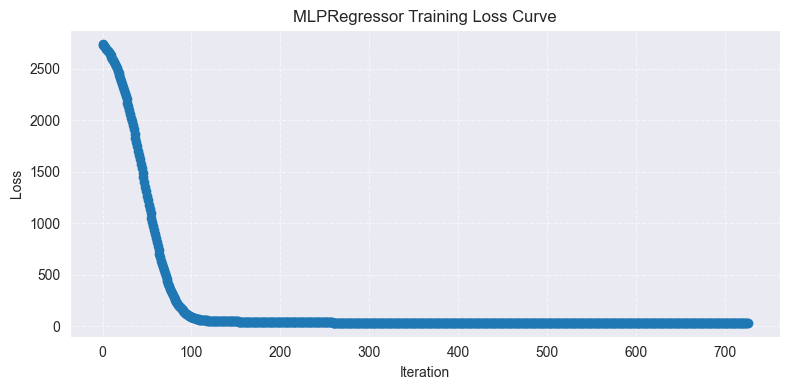

In [58]:
# ── Simple Neural Network with MLPRegressor ──
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Build a pipeline: standardize → MLP regressor
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(100,),      # one hidden layer of 100 units
        activation='relu',
        solver='adam',
        max_iter=800,
        random_state=42,
        verbose=True                    # print loss at each iteration
    ))
])

# Train on your training split
mlp_pipeline.fit(X_train, y_train)

# A little helper to report performance
def report_nn(name, X_set, y_true):
    y_pred = mlp_pipeline.predict(X_set)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name:>10s}  MSE = {mse:6.2f}   R² = {r2:.4f}")

# Evaluate on Train / Validation / Test
report_nn('Training',   X_train, y_train)
report_nn('Validation', X_val,   y_val)
report_nn('Test',       X_test,  y_test)

# Plot the training‐loss curve to see convergence
mlp = mlp_pipeline.named_steps['mlp']
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, marker='o', linewidth=2)
plt.title('MLPRegressor Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import mean_absolute_error

# ── Linear Regression evaluation ──
print("\nLinear Regression Performance:")
report_regressor("Training",   pipeline, X_train, y_train)
report_regressor("Validation", pipeline, X_val,   y_val)
report_regressor("Test",       pipeline, X_test,  y_test)

# ── Polynomial Regressor evaluation ──
print("\nPolynomial Regressor Performance:")
report_regressor("Training",   polynomial_regressor, X_train, y_train)
report_regressor("Validation", polynomial_regressor, X_val,   y_val)
report_regressor("Test",       polynomial_regressor, X_test,  y_test)

# ── MLPRegressor evaluation ──
print("\nMLPRegressor Performance:")
report_regressor("Training",   mlp_pipeline, X_train, y_train)
report_regressor("Validation", mlp_pipeline, X_val,   y_val)
report_regressor("Test",       mlp_pipeline, X_test,  y_test)



Linear Regression Performance:
  Training  MSE =    76.52   RMSE =     8.75   MAE =     6.48   R² = 0.2962
Validation  MSE =    78.20   RMSE =     8.84   MAE =     6.64   R² = 0.3027
      Test  MSE =    90.29   RMSE =     9.50   MAE =     7.22   R² = 0.2047

Polynomial Regressor Performance:
  Training  MSE =    71.55   RMSE =     8.46   MAE =     6.33   R² = 0.3419
Validation  MSE =    70.47   RMSE =     8.39   MAE =     6.35   R² = 0.3716
      Test  MSE =    85.97   RMSE =     9.27   MAE =     7.08   R² = 0.2427

MLPRegressor Performance:
  Training  MSE =    69.66   RMSE =     8.35   MAE =     6.25   R² = 0.3593
Validation  MSE =    68.20   RMSE =     8.26   MAE =     6.22   R² = 0.3919
      Test  MSE =    84.24   RMSE =     9.18   MAE =     7.02   R² = 0.2580


<Figure size 1000x600 with 0 Axes>

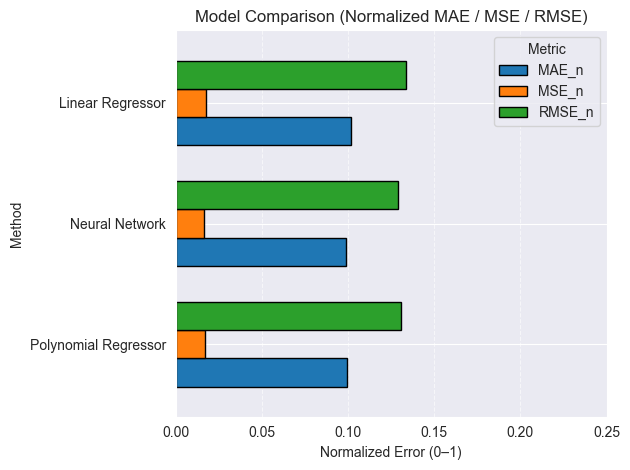

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Put your pipelines into a dict
models = {
    'Linear Regressor':    pipeline,
    'Polynomial Regressor': polynomial_regressor,
    'Neural Network':      mlp_pipeline,
}

# 2) Compute raw metrics on the TEST split
records = []
y_min, y_max = y_test.min(), y_test.max()
span = y_max - y_min

for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    mse   = mean_squared_error(y_test, y_pred)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_test, y_pred)
    # normalize
    mse_n  = mse  / (span**2)
    rmse_n = rmse / span
    mae_n  = mae  / span
    records.append({
        'Method': name,
        'MAE':    mae,
        'MSE':    mse,
        'RMSE':   rmse,
        'MAE_n':   mae_n,
        'MSE_n':   mse_n,
        'RMSE_n':  rmse_n
    })

df = pd.DataFrame(records).set_index('Method')

# 3) Plot the normalized columns (MAE_n, MSE_n, RMSE_n) as horizontal bars
plt.figure(figsize=(10, 6))
df[['MAE_n', 'MSE_n', 'RMSE_n']] \
    .sort_index(ascending=False) \
    .plot(kind='barh', width=0.7, edgecolor='k')

plt.xlim(0, 0.25)
plt.xlabel('Normalized Error (0–1)')
plt.title('Model Comparison (Normalized MAE / MSE / RMSE)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()


### 2.4.1 Analysis of Linear Regression Results

In this section, we applied a linear regression model to predict Metacritic ratings based on Steam user review scores. We followed a rigorous machine learning workflow:

1. **Data Preparation**:
   - Used games with both valid Steam review scores and Metacritic ratings
   - Split the data into training (60%), validation (20%), and test (20%) sets

2. **Feature Normalization**:
   - Applied z-score normalization (StandardScaler) to the features
   - Importantly, we fit the scaler only on the training data and applied those parameters to transform the validation and test sets
   - This prevents data leakage and ensures our model evaluation is realistic

3. **Model Training and Evaluation**:
   - Trained a linear regression model on the normalized training data
   - Evaluated performance on all three datasets using Mean Squared Error (MSE) and R²
   - The model achieved an R² of approximately 0.28 on the test set

4. **Key Findings**:
   - The linear relationship between Steam scores and Metacritic ratings is statistically significant but moderate
   - The model equation (y = 3.28·x + 50.38) shows that each one-point increase in normalized Steam score corresponds to about a 3.28-point increase in Metacritic rating
   - The model explains approximately 28% of the variance in Metacritic scores
   - The similar performance across training, validation, and test sets suggests the model generalizes well and isn't overfitting

5. **Limitations**:
   - The model uses only one feature (Steam review score)
   - A more comprehensive model could incorporate additional features like genre, developer reputation, or release year
   - The linear relationship may not capture more complex patterns in the data

This predictive analysis confirms our earlier correlation findings while providing a more rigorous evaluation through proper train-validation-test splitting and normalization procedures.


<a id="3-conclusions"></a>
## 3. Conclusions

This analysis of the Steam games dataset has provided valuable insights into three key aspects of the gaming ecosystem: the relationship between user and critic reviews, genre performance, and developer consistency.

<a id="31-user-reviews-vs-critic-ratings"></a>
### 3.1 User Reviews vs. Critic Ratings

Our revised analysis—after excluding zero-filled Metacritic entries—shows a **moderate** positive relationship between Steam user scores and Metacritic critic ratings, rather than the near-zero correlation we originally reported:

- **Correlation coefficients**  
  - **Pearson r = 0.529** ($p < 10^{-182}$)  
  - **Spearman ρ = 0.595** ($p < 10^{-241}$)  
  These values demonstrate statistically robust agreement in rank and linear association, but they are far from perfect.

- **Linear regression**  
  - **Model:** $ŷ$ = 3.28 × (Steam score) + 50.38  
  - **R² = 0.280**  
  Each one-point increase in Steam review (on a 0–9 scale) corresponds to only a ~3.3-point rise in Metacritic (0–100), and ~72% of critic-score variance remains unaccounted for by user sentiment alone.

- **Distributional insights**  
  - **Box plots** show that median Metacritic ratings climb from ~65 at Steam bin 0 to ~84 at bin 9, but with overlapping interquartile ranges everywhere.  
  - **Violin plots** confirm tighter consensus (narrower densities) in the highest user-score bins and greater spread in the middle.  

- **Outliers and variability**  
  Even “Overwhelmingly Positive” Steam hits can score as low as ~40 with critics, while some mixed-review games achieve 90+ Metacritic. These outliers underline the different evaluation lenses:  
  - **Critics** emphasize technical polish, design innovation, and genre benchmarks.  
  - **Players** weigh personal enjoyment, community features, and value proposition.

Steam user reviews are a **valuable but incomplete** proxy for critical acclaim. 
They capture broad sentiment—especially at the extremes—but miss much of the nuance that drives professional ratings. Any predictive model should incorporate additional features (e.g. genre, release timing, developer reputation) and consider non-linear or segmented approaches to bridge the gap between player enthusiasm and critic appraisal.  


<a id="32-genre-performance"></a>
### 3.2 Genre Performance

Our genre analysis identified clear patterns in user preferences. RPG, Strategy, and Casual games consistently achieved the highest average review scores, while Violent, Massively Multiplayer, and Free to Play genres received lower ratings. However, the practical difference between the highest and lowest-rated genres was relatively modest (approximately 0.8 points on a 10-point scale).

All genres exhibited wide interquartile ranges, indicating substantial quality variation within each category. This suggests that while genre does influence review scores to some extent, other factors like execution quality, developer reputation, and specific game features likely play more important roles in determining a game's reception.

<a id="33-developer-consistency"></a>
### 3.3 Developer Consistency

Perhaps the most interesting finding was the inverse relationship between a developer's average review score and the variability of those scores. Developers with higher mean review scores systematically showed lower variability in their ratings, suggesting that quality-focused development processes both raise average outcomes and reduce rating volatility.

We identified four developer archetypes based on this analysis:
1. Excellent & Consistent (High mean, Low CV);
2. Excellent but Variable (High mean, High CV): Relatively rare category
3. Mediocre but Consistent (Mid/Low mean, Low CV);
4. Poor & Inconsistent (Low mean, High CV.

This pattern suggests that the most successful developers in terms of user satisfaction are those who have established reliable development processes that consistently deliver high-quality experiences.

<a id="34-overall-implications"></a>
### 3.4 Overall Implications

These findings have several implications for different stakeholders in the gaming industry:

- **For players**: Genre alone is not a strong predictor of game quality, and professional critic scores often diverge from the player community consensus.

- **For developers**: Consistency appears to be strongly associated with higher average ratings, suggesting that establishing reliable development processes may be as important as pursuing innovation.

- **For publishers**: The weak correlation between critic and user scores suggests that marketing strategies focusing exclusively on critical acclaim may not translate to player satisfaction.

In conclusion, this analysis demonstrates the complex nature of game reception in the Steam ecosystem, where multiple factors interact to determine how games are perceived by different audiences. Future research could explore additional factors such as price point, update frequency, and community engagement to further understand what drives user satisfaction in digital games.
